In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 디바이스 설정
import tensorflow as tf
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,7
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
sp500 = pd.read_csv('/content/drive/My Drive/데이터/S&P_170103_final.csv')

In [ ]:
print(sp500.shape)
sp500.tail() # rv5 sqrt 한 것이 RV

(909, 5)


,date,snp,snp500,rv5,RV
904,2020-08-17,25.23,25.20,0.000008,0.002907
905,2020-08-18,29.00,25.76,0.000033,0.005748
906,2020-08-19,26.10,28.00,0.000030,0.005488
907,2020-08-20,25.23,26.32,0.000018,0.004251
908,2020-08-21,26.68,24.92,0.000019,0.004413


In [ ]:
y = pd.DataFrame(sp500.RV.values[1:])
RV_d = pd.DataFrame(sp500.RV[:-1].values)
RV_w = pd.DataFrame(sp500.RV.rolling(5).mean()[:-1].values)
RV_m = pd.DataFrame(sp500.RV.rolling(22).mean()[:-1].values)

In [ ]:
sp500_RV = pd.concat([RV_d, RV_w, RV_m, y], axis=1).dropna()
sp500_RV.columns = ['rv_d', 'rv_w', 'rv_m', 'y']

In [ ]:
sp500_RV

,rv_d,rv_w,rv_m,y
21,0.004020,0.003949,0.003819,0.002837
22,0.002837,0.004002,0.003678,0.002499
23,0.002499,0.003606,0.003626,0.002756
24,0.002756,0.003330,0.003595,0.003490
25,0.003490,0.003120,0.003578,0.002516
...,...,...,...,...
903,0.005776,0.006365,0.006691,0.002907
904,0.002907,0.005808,0.006326,0.005748
905,0.005748,0.005031,0.006247,0.005488
906,0.005488,0.005014,0.006264,0.004251


## LSTM

In [ ]:
def split_xy3(dataset, time_steps, y_column):
  x, y = list(), list()
  for i in range(len(dataset)):
    x_end_number = i + time_steps
    y_end_number = x_end_number + y_column - 1
    if y_end_number > len(dataset):
      break
    tmp_x = dataset[i:x_end_number, :-1]
    tmp_y = dataset[x_end_number-1:y_end_number, -1]
    x.append(tmp_x)
    y.append(tmp_y)
  return np.array(x), np.array(y)

In [ ]:
x, y = split_xy3(np.array(sp500_RV), 20, 1)

In [ ]:
print(x.shape)
print(y.shape)

(868, 20, 3)
(868, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 3)))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.fit(x, y, epochs=20, batch_size=1)

Epoch 1/300
868/868 [==============================] - 6s 5ms/step - loss: 2.6455e-05
Epoch 2/300
868/868 [==============================] - 4s 5ms/step - loss: 2.0842e-05
Epoch 3/300
868/868 [==============================] - 4s 5ms/step - loss: 1.8652e-05
Epoch 4/300
868/868 [==============================] - 4s 5ms/step - loss: 1.5814e-05
Epoch 5/300
868/868 [==============================] - 4s 5ms/step - loss: 1.1374e-05
Epoch 6/300
868/868 [==============================] - 4s 5ms/step - loss: 1.3442e-05
Epoch 7/300
868/868 [==============================] - 4s 5ms/step - loss: 1.3553e-05
Epoch 8/300
868/868 [==============================] - 4s 5ms/step - loss: 1.4429e-05
Epoch 9/300
868/868 [==============================] - 4s 5ms/step - loss: 1.7120e-05
Epoch 10/300
868/868 [==============================] - 4s 5ms/step - loss: 2.3254e-05
Epoch 11/300
868/868 [==============================] - 4s 5ms/step - loss: 1.1747e-05
Epoch 12/300
868/868 [==============================

In [ ]:
predict_lstm = model.predict(x)

## HAR

In [ ]:
import statsmodels.api as sm

X = sp500_RV[['rv_d', 'rv_w', 'rv_m']]
X = sm.add_constant(X)
y = sp500_RV['y']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

# Print out the statistics
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     1041.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):          2.55e-289
Time:                        21:52:21   Log-Likelihood:                 3846.7
No. Observations:                 887   AIC:                            -7685.
Df Residuals:                     883   BIC:                            -7666.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.623      0.000       0.000       0.001
rv_d           0.4618      0.041     11.355      0.000       0.382       0.542
rv_w           0.5266      0.054      9.720      0.000       0.420       0.633
rv_m          -0.0791      0.034     -2.297      0.022      -0.147      -0.012
==============================================================================
Omnibus:                      746.424   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50933.809
Skew:                           3.350   Prob(JB):                         0.00
Kurtosis:                      39.514   Cond. No.                         638.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
predict_har = model.predict(X)

## 비교

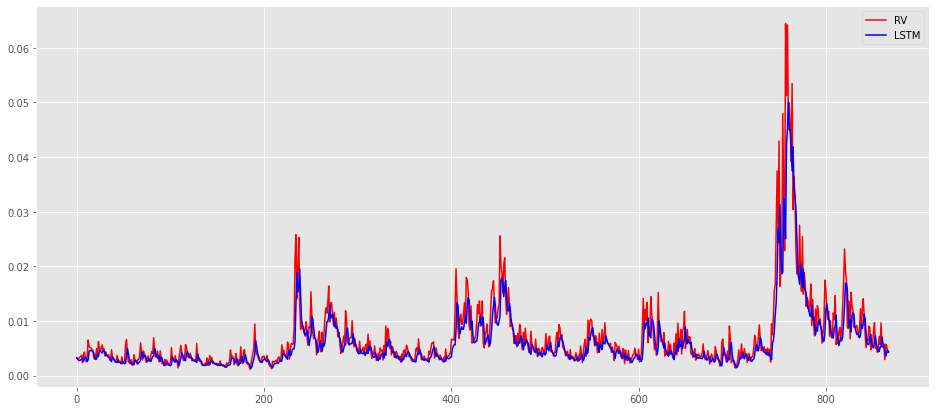

In [ ]:
plt.plot(sp500_RV.y[19:].values, label='RV', color='red')
plt.plot(predict_lstm, label='LSTM', color='blue')
#plt.plot(predict_har[19:].values, label='HAR')
plt.legend()

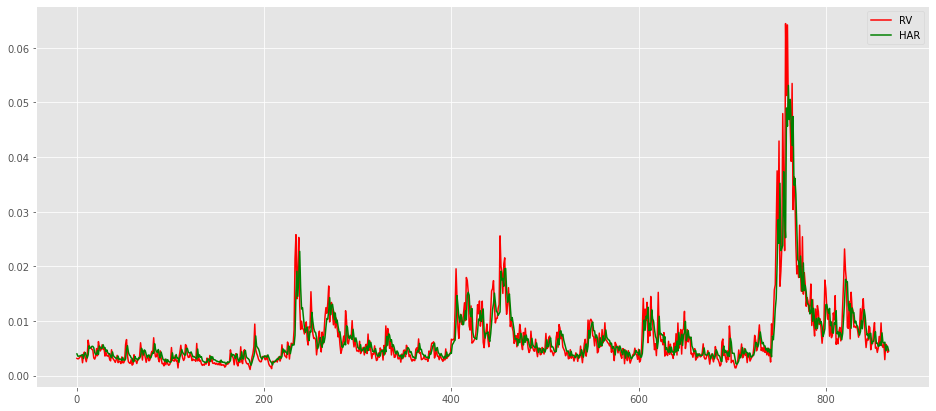

In [ ]:
#plt.plot(predict_lstm, label='LSTM')
plt.plot(sp500_RV.y[19:].values, label='RV', color='red')
plt.plot(predict_har[19:].values, label='HAR', color='green')
plt.legend()

In [ ]:
# mse
lstm_mse = np.mean((sp500_RV.y[19:].values - predict_lstm)**2)
har_mse = np.mean((sp500_RV.y[19:].values - predict_har[19:].values)**2)

pd.DataFrame({'lstm':lstm_mse, 'har':har_mse}, index=['mse'])

,lstm,har
mse,0.000079,0.00001
